# Recommendations with IBM

In this notebook, I am implementing recommendation methods on a real-world article dataset from the IBM Watson Studio platform.

Please see the table of contents for the different sections covering different phases of the work / different types of recommendation logics: 


#### Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Reading in the datasets, reviewing key summary statistics and cleaning the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle
import re
from collections import Counter
from nltk.tag import pos_tag

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
df.article_id = df.article_id.astype(int)
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head(10)

,article_id,title,email
0,1430,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
5,1432,visualize data with the matplotlib library,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6,1429,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
7,593,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8,1314,healthcare python streaming application demo,8b6fb4bbb7a27b336ba35420bf58337d877455c7
9,1185,classify tumors with machine learning,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4


In [2]:
df_content.head(10)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4
5,Compose is all about immediacy. You want a new...,Using Compose's PostgreSQL data browser.,Browsing PostgreSQL Data with Compose,Live,5
6,UPGRADING YOUR POSTGRESQL TO 9.5Share on Twitt...,Upgrading your PostgreSQL deployment to versio...,Upgrading your PostgreSQL to 9.5,Live,6
7,Follow Sign in / Sign up 135 8 * Share\r\n * 1...,For a company like Slack that strives to be as...,Data Wrangling at Slack,Live,7
8,* Host\r\n * Competitions\r\n * Datasets\r\n *...,Kaggle is your home for data science. Learn ne...,Data Science Bowl 2017,Live,8
9,THE GRADIENT FLOW\r\nDATA / TECHNOLOGY / CULTU...,[A version of this post appears on the O’Reill...,Using Apache Spark to predict attack vectors a...,Live,9


`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [3]:
# Some descriptive statistics
art_cnt = df.groupby('email').article_id.count()
art_cnt.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

(0, 50)

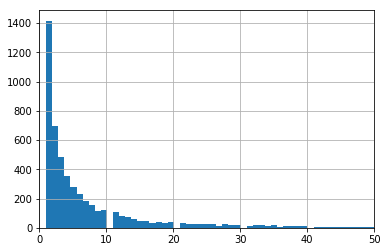

In [4]:
# Distribution of user-article interaction counts
art_cnt.hist(bins = 400)
plt.xlim([0, 50])

In [5]:
median_val = int(np.quantile(art_cnt, 0.5))
print(f'50% of individuals interact with {median_val} articles or fewer.')
max_views_by_user = art_cnt.max()
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Exploring and removing duplicate articles from the **df_content** dataframe.  

In [6]:
df_content[df_content.article_id.duplicated(keep = False)].sort_values(by = 'article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [7]:
df_content = df_content[~df_content.article_id.duplicated()]

In [8]:
# Just checking: duplicates in the user interaction dataset
df[df.duplicated(keep = False)].sort_values(by = 'article_id').head(10)

,article_id,title,email
1937,0,detect malfunctioning iot sensors with streami...,384255292a8223e84f05ca1e1deaa450c993e148
1936,0,detect malfunctioning iot sensors with streami...,384255292a8223e84f05ca1e1deaa450c993e148
1935,0,detect malfunctioning iot sensors with streami...,384255292a8223e84f05ca1e1deaa450c993e148
45233,2,"this week in data science (april 18, 2017)",75b11547437d86c21fa34ecf3e15bb8ec4f79c69
5510,2,"this week in data science (april 18, 2017)",3427a5a4065625363e28ac8e85a57a9436010e9c
10585,2,"this week in data science (april 18, 2017)",0286bfe26356436658cf4b29b232f0700f0bb9ce
7020,2,"this week in data science (april 18, 2017)",aedcfe1a2d62760adc7db57a1489deb2e78f1858
33335,2,"this week in data science (april 18, 2017)",77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a
8769,2,"this week in data science (april 18, 2017)",3427a5a4065625363e28ac8e85a57a9436010e9c
45243,2,"this week in data science (april 18, 2017)",75b11547437d86c21fa34ecf3e15bb8ec4f79c69


`3.` Project questions:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [9]:
# a
art_cnt_art = df.groupby('article_id').email.count()

In [10]:
unique_articles = art_cnt_art[art_cnt_art > 0].shape[0]
print(f'The number of unique articles that have at least one interaction: {unique_articles}')
total_articles = df_content.article_id.nunique()
print(f'The number of unique articles on the IBM platform: {total_articles}')
unique_users = df.email.nunique()
print(f'The number of unique users: {unique_users}')
user_article_interactions = df.shape[0]
print(f'The number of user-article interactions: {user_article_interactions}')

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
print('Most viewed article:', art_cnt_art.idxmax())
print('No of views on most viewed article:', art_cnt_art.max())

Most viewed article: 1429
No of views on most viewed article: 937


In [12]:
most_viewed_article_id = str(float(art_cnt_art.idxmax()))
max_views = art_cnt_art.max()

In [13]:
# Mapping email hashes to simpler integer user_ids

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [14]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't have ratings for whether a user liked an article or not, we have only data on whether a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with overall.

`1.` Defining simple functions for rank-based filtering

In [15]:
def get_top_articles(n, df = df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    OUTPUT:
    top_articles - (list) top 'n' article titles 
    '''
    top_articles = df.groupby(['article_id', 'title']).count().reset_index().sort_values(by = 'user_id', ascending = False)[:n]
    return top_articles.title

#%%
def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    OUTPUT:
    top_articles - (list) the top 'n' article IDs
    '''
    top_articles = df.groupby(['article_id', 'title']).count().reset_index().sort_values(by = 'user_id', ascending = False)[:n]
    return top_articles.article_id

In [16]:
# Reviewing a few examples
print(get_top_articles(10))
print(get_top_article_ids(10))

699           use deep learning for image classification
625          insights from new york car accident reports
701                       visualize car data with brunel
697    use xgboost, scikit-learn & ibm watson machine...
652    predicting churn with the spss random tree alg...
614         healthcare python streaming application demo
600    finding optimal locations of new store using d...
526             apache spark lab, part 1: basic concepts
518              analyze energy consumption in buildings
608    gosales transactions for logistic regression m...
Name: title, dtype: object
699    1429
625    1330
701    1431
697    1427
652    1364
614    1314
600    1293
526    1170
518    1162
608    1304
Name: article_id, dtype: int64


In [17]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Creating user-item matrix

In [18]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    OUTPUT:
    user_item - user item matrix 
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with an article and a 0 otherwise
    '''
    user_item = df[~df.duplicated()].groupby(['user_id', 'article_id']).count().unstack().fillna(0).astype('int8')
    user_item.columns = user_item.columns.droplevel()
    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)

In [19]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Defining function for user-user similarities

In [20]:
def find_similar_users(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of similar users, from most similar to least similar
    '''

    # compute similarity of each user to the provided user
    # sort by similarity
    sim = pd.Series(data = np.array(user_item.loc[user_id].dot(user_item.transpose())), index = range(1, user_item.shape[0]+1))
    sim.drop(user_id, axis = 0, inplace = True)
    sim.sort_values(ascending = False, inplace = True)
    most_similar_users = list(sim.index)
    user_similarities = sim.values
       
    return most_similar_users, user_similarities # return a list of the users in order from most to least similar

In [21]:
# Spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[0][:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[0][:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[0][:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Defining functions for generating user recommendations

In [38]:
#%%
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for art_id in article_ids:
        article_names.append(df.title[df.article_id == art_id].values[0])
    
    return article_names # Return the article names associated with list of article ids

#%%
def get_user_articles(user_id, user_item = user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = list(user_item.columns[user_item.loc[user_id].values == 1])
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

#%%
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    OUTPUT:
    recs - (list) a list of recommendations for the user
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    '''
    sim_usrs, _ = find_similar_users(user_id)
    tgt_usr_art_ids, tgt_usr_art_nms = get_user_articles(user_id)
    recs = []
    for usr in sim_usrs:
        usr_art_ids, _ = get_user_articles(usr)
        recs += list(set(usr_art_ids).difference(set(tgt_usr_art_ids)))
        d = len(recs) - m
        if d == 0:
            break
        if d > 0:
            recs = recs[:-d]
            break
    return recs # return your recommendations for this user_id 

In [39]:
# Check Results
user_user_recs(1, 10) # Return 10 recommendations for user 1

[1025, 2, 517, 524, 12, 14, 16, 26, 1051, 28]

In [40]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Making collaborative filtering results more sophisticated  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user, we choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [41]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u       
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where highest of each is higher in the dataframe
    '''

    # compute similarity of each user to the provided user
    # sort by similarity and article interactions
    neighbors, sims = find_similar_users(user_id)
    neighbors_df = pd.DataFrame(data = sims, index = neighbors, columns = ['similarity'])
    neighbors_df = neighbors_df.merge(df.groupby('user_id')['article_id'].count().sort_values(ascending = False).drop(user_id), how = 'left', left_index = True, right_index = True)
    neighbors_df.columns = ['similarity', 'num_interactions']
        
    return neighbors_df # Return the dataframe specified in the doc_string

def user_user_recs_part2(user_id, df = df, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.
    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    sim_usrs = get_top_sorted_users(user_id)
    tgt_usr_art_ids, tgt_usr_art_nms = get_user_articles(user_id)
    print('Target user article IDs:', tgt_usr_art_ids)
    print('Target user article names:')
    for article in tgt_usr_art_nms:
        print('-', article)
    print()
    recs = []
    for usr in sim_usrs.index:
        usr_art_ids, usr_art_nms = get_user_articles(usr)
        print('Next most similar user art IDs:', usr_art_ids)
        props = np.array(list(set(usr_art_ids).difference(set(tgt_usr_art_ids))))
        print('Props:', props)
        props_cnts = np.zeros(props.shape)
        for i in range(len(props)):
            props_cnts[i] = df.article_id[df.article_id == props[i]].shape[0]
        print('Props_cnt:', props_cnts)
        recs += list(pd.Series(props_cnts, index = props).sort_values(ascending = False).index)
        print('Recs:', recs)
        print()
        d = len(recs) - m
        if d == 0:
            break
        if d > 0:
            recs = recs[:-d]
            break
    rec_names = get_article_names(recs)
    return recs, rec_names

In [42]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
for name in rec_names:
    print('-', name)

Target user article IDs: [232, 844, 1320]
Target user article names:
- self-service data preparation with ibm data refinery
- use the cloudant-spark connector in python notebook
- housing (2015): united states demographic measures

Next most similar user art IDs: [43, 109, 111, 112, 164, 213, 225, 232, 313, 337, 379, 482, 528, 667, 684, 723, 903, 939, 967, 1006, 1035, 1154, 1160, 1162, 1165, 1172, 1181, 1184, 1185, 1276, 1277, 1304, 1314, 1320, 1330, 1338, 1351, 1357, 1360, 1364, 1366, 1368, 1386, 1396, 1397, 1400, 1427, 1429, 1430, 1431, 1433, 1437]
Props: [1154  903 1160 1162 1035 1165  528 1427 1172 1429 1430 1431 1304 1433
  667 1181 1437 1184 1185 1314  164   43  684  939 1330  313 1338  967
 1351 1357 1360  337  723 1364  213 1366 1368  225  482 1386  109 1006
  111  112 1396 1397 1400  379 1276 1277]
Props_cnt: [ 14.  54. 433. 512.  18. 372.  32. 643. 363. 937. 336. 671. 483. 108.
  28. 116. 218.  73. 442. 614. 222. 460. 107. 135. 927.  15. 382.  45.
 457. 123. 214.  34.  95. 62

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [43]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).index[0]
user131_10th_sim = get_top_sorted_users(131).index[9]

In [44]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Given that we don't have any information on the user's product preferences, the only thing to do is to recommend the most popular articles overall.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [45]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [46]:
assert set(new_user_recs) == set([1314, 1429, 1293, 1427, 1162, 1364, 1304, 1170, 1431, 1330]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part, I build recommendations based on matrix factorization.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part IV** of the notebook. 

In [47]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [48]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [49]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

**In this case, we are looking at user-item interaction only (user has read or not read an article), in contrast to the FunkSVD lesson where we were looking at, and trying to predict, ratings. In this case, we could pad missing values with zeros because where there is no value we know the user didn't have any interaction with the article. In the FunkSVD case, we couldn't do this as ratings were missing in the original at certain places and we couldn't have imputed the actual values. And "traditional" SVD only works if the original matrix has no missing values.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

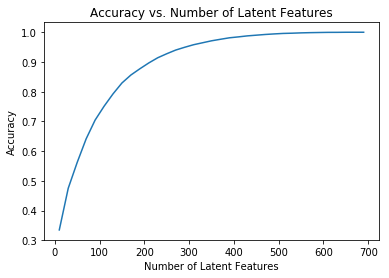

In [50]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many movies can we make predictions for in the test set?  
* How many movies are we not able to make predictions for because of the cold start problem?

In [51]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = [x for x in user_item_test.index]
    test_arts = [x for x in user_item_test.columns]
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [52]:
user_item_train.shape

(4487, 714)

In [53]:
(df_test).shape

(5993, 3)

In [54]:
user_item_test.shape

(682, 574)

In [55]:
# How many users can we make predictions for in the test set?
len(set(user_item_train.index).intersection(set(user_item_test.index)))

20

In [56]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
user_item_test.shape[0] - len(set(user_item_train.index).intersection(set(user_item_test.index)))

662

In [57]:
# How many movies can we make predictions for in the test set?
len(set(user_item_train.columns).intersection(set(user_item_test.columns)))

574

In [58]:
# How many movies in the test set are we not able to make predictions for because of the cold start problem?
user_item_test.shape[1] - len(set(user_item_train.columns).intersection(set(user_item_test.columns)))

0

In [59]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [82]:
# fit SVD on the user_item_train matrix
test_users = user_item_train.index.isin(user_item_test.index)
test_movies = user_item_train.columns.isin(user_item_test.columns)
user_item_test_new = user_item_test[user_item_test.index.isin(user_item_train.index.tolist())]

u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices = False)
u_test, vt_test = u_train[test_users, :], vt_train[:, test_movies]

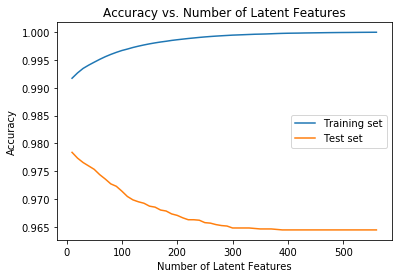

In [83]:
num_latent_feats = np.arange(10,570,10)
sum_errs_train = []
sum_errs_test = []
for k in num_latent_feats:
    # restructure with k latent features
    u_lim_train, s_lim_train, vt_lim_train = u_train[:, :k], np.diag(s_train[:k]), vt_train[:k,:]
    u_lim_test, vt_lim_test = u_test[:,:k], vt_test[:k,:]

    # take dot product
    train_user_item_est = np.around(np.dot(np.dot(u_lim_train, s_lim_train), vt_lim_train))
    test_user_item_est = np.around(np.dot(np.dot(u_lim_test, s_lim_train), vt_lim_test))

    diffs_train = np.subtract(user_item_train, train_user_item_est)
    diffs_test = np.subtract(user_item_test_new, test_user_item_est)

    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)

plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0] * user_item_train.shape[1]), label = 'Training set');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(20*574), label = 'Test set');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend(loc = 'right')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**It seems that there is not much difference overall in prediction error between different numbers of latent features. At the same time, even with the very limited set of 20 test users we can see that accuracy first increases as we go from 10 latent features to a higher number, then it peaks at 90 and subsequently decreases back to under the level that was achievable with a mere 10 latent features.**

**I believe this shows well that although on the training set the accuracy remains high - which is, in turn, a form of overfitting in the case of high number of latent features -, on the test set the accuracy - albeit in a low range - shows a realistic variance.**

**As to how we could measure the actual real-world accuracy of any of the recommenders demonstrated above, the answer is simple: an A-B testing framework needs to be set up, where we randomly assign a conventional rank-based or market basket analysis based recommender to a control group and a combination of collaborative and matrix factorization based recommendations to a treatment group. The invariant measure in the test would be the 50/50 split between the control and treatment groups which can be validated by a simple hypothesis test after the testing has been run. The measure we would be testing could be either the click rate of the recommendations or the actual conversion (number of purchases) from the recommendations. The difference in the target metric can be again validated by a hypothesis test.**